# Import necessary libraries

In [24]:
# pip install pandas matplotlib wordcloud nltk vaderSentiment scikit-learn pytest

In [25]:
!pip install vaderSentiment

In [26]:
!pip install swifter

In [27]:
import kagglehub

import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import re
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, classification_report

# library used for showing progress bar
from tqdm.notebook import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

# Swifter library speeds up applying functions on pandas DataFrames or Series by
# automatically choosing vectorization, multithreading, or parallel processing.
# It requires minimal code changes, making it ideal for handling large datasets efficiently.
import swifter

# unit testing framework
import unittest
from unittest.mock import patch
from unittest.mock import MagicMock, patch
from io import StringIO

# Download stopwords from nltk

In [28]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

# Download dataset from Kaggle

In [29]:
path = kagglehub.dataset_download("prkhrawsthi/twitter-sentiment-dataset-3-million-labelled-rows")

print("Path to dataset files:", path)

Path to dataset files: /root/.cache/kagglehub/datasets/prkhrawsthi/twitter-sentiment-dataset-3-million-labelled-rows/versions/1


In [30]:
!ls /root/.cache/kagglehub/datasets/prkhrawsthi/twitter-sentiment-dataset-3-million-labelled-rows/versions/1

twitter_dataset.csv


In [31]:
!mkdir /content/dataset

mkdir: cannot create directory ‘/content/dataset’: File exists


In [32]:
!cp /root/.cache/kagglehub/datasets/prkhrawsthi/twitter-sentiment-dataset-3-million-labelled-rows/versions/1/twitter_dataset.csv /content/dataset/

# Read dataset using Pandas library

In [33]:
# read the dataset using pandas library
df_tweets = pd.read_csv("/content/dataset/twitter_dataset.csv")

# print the count
df_tweets.count()

,0
Unnamed: 0,3142403
tweet,3142403
sentiment,3142321


# Perform EDA on the dataset

In [34]:
# Display first 5 rows
df_tweets.head()

,Unnamed: 0,tweet,sentiment
0,0,is upset that he can't update his Facebook by ...,0.0
1,1,@Kenichan I dived many times for the ball. Man...,0.0
2,2,my whole body feels itchy and like its on fire,0.0
3,3,"@nationwideclass no, it's not behaving at all....",0.0
4,4,@Kwesidei not the whole crew,0.0


In [35]:
# Display last 5 rows
df_tweets.tail()

,Unnamed: 0,tweet,sentiment
3142398,3142398,"With ad revenues falling, what’s the impact on...",2.0
3142399,3142399,RT @KelvinSCWong: Well another point to add to...,2.0
3142400,3142400,$ITOX working on a contract with a fortune 500...,2.0
3142401,3142401,"$DIS it could break the 120 pin, then 125&gt; ...",2.0
3142402,3142402,Amedisys Inc $AMED COO Christopher Gerard Sell...,2.0


In [36]:
df_tweets.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3142403 entries, 0 to 3142402
Data columns (total 3 columns):
 #   Column      Dtype  
---  ------      -----  
 0   Unnamed: 0  int64  
 1   tweet       object 
 2   sentiment   float64
dtypes: float64(1), int64(1), object(1)
memory usage: 71.9+ MB


In [37]:
# display percentage of missing values present in each feature
features_with_missingvalues = [features for features in df_tweets.columns if df_tweets[features].isnull().sum()>1]

print("Total number of features with missing values is {}".format(len(features_with_missingvalues)))

for feature in features_with_missingvalues:
    print('Feature {} has {} % missing values'.format(feature, np.round(df_tweets[feature].isnull().mean(), 5)))

Total number of features with missing values is 1
Feature sentiment has 3e-05 % missing values


In [38]:
df_tweets.dropna(inplace=True)
df_tweets.count()

,0
Unnamed: 0,3142321
tweet,3142321
sentiment,3142321


In [39]:
# display percentage of missing values present in each feature
features_with_missingvalues = [features for features in df_tweets.columns if df_tweets[features].isnull().sum()>1]

print("Total number of features with missing values is {}".format(len(features_with_missingvalues)))

for feature in features_with_missingvalues:
    print('Feature {} has {} % missing values'.format(feature, np.round(df_tweets[feature].isnull().mean(), 5)))

Total number of features with missing values is 0


# Define Utils class for all helper methods

In [40]:
class Utils:
  # A dictionary where keys are category names, and values are lists of keywords related to each category.
  categories = {
    "Politics": ["election", "vote", "president", "government", "policy"],
    "Sports": ["football", "cricket", "soccer", "game", "match"],
    "Health": ["covid", "pandemic", "health", "vaccine", "virus"],
    "Technology": ["tech", "AI", "machine learning", "gadget", "software"],
    "Entertainment": ["movie", "music", "actor", "show", "series"]
  }

  # Define a helper function to match a tweet to a category based on keywords
  def match_category(self, text):
    for category, keywords in self.categories.items():
      for keyword in keywords:
        if keyword.lower() in text.lower():
          return category
    return "Other"  # Default category if no match is found

  # Generate random timestamps within the date range
  def random_date(self, start, end):
      return start + pd.to_timedelta(
          np.random.randint(0, int((end - start).total_seconds())), unit='s'
      )

  # Add a random datetime column to the dataset for sentiment fluctuation analysis.
  # Args: start_date (str): The start date in 'YYYY-MM-DD' format.
  #       end_date (str): The end date in 'YYYY-MM-DD' format.
  #       df: DataFrame to which the datetime column needs to be added
  # Returns: pd.DataFrame: The updated DataFrame with an added 'timestamp' column.
  def add_random_datetime(self, start_date, end_date, df):
    # Convert start and end dates to pandas Timestamps
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    # Apply the random timestamp generation
    df['timestamp'] = [self.random_date(start, end) for _ in range(len(df))]
    return df


# Unit tests for Utils class

In [41]:
class TestUtils(unittest.TestCase):

    def setUp(self):
        # Initialize Utils instance
        self.utils = Utils()

    def test_match_category(self):
        # Test with a text containing a keyword from each category
        self.assertEqual(self.utils.match_category("The election results are out."), "Politics")
        self.assertEqual(self.utils.match_category("The football match was thrilling!"), "Sports")
        self.assertEqual(self.utils.match_category("The pandemic has impacted many lives."), "Health")
        self.assertEqual(self.utils.match_category("AI is transforming industries."), "Technology")
        self.assertEqual(self.utils.match_category("I loved the new movie."), "Entertainment")

        # Test with a text containing no matching keywords
        self.assertEqual(self.utils.match_category("I generally enjoy my trips to the beach."), "Other")

        # Test case insensitivity
        self.assertEqual(self.utils.match_category("Election season is here."), "Politics")
        self.assertEqual(self.utils.match_category("The MUSIC is amazing."), "Entertainment")

    @patch('numpy.random.randint')
    def test_random_date(self, mock_randint):
        # Mock random number generation
        mock_randint.return_value = 3600  # 1 hour in seconds

        start_date = pd.to_datetime("2023-01-01")
        end_date = pd.to_datetime("2023-01-02")
        result = self.utils.random_date(start_date, end_date)

        # Verify the result is within the range
        self.assertGreaterEqual(result, start_date)
        self.assertLess(result, end_date)

        # Verify the exact timestamp (with mock)
        expected_result = start_date + pd.to_timedelta(3600, unit='s')
        self.assertEqual(result, expected_result)

    @patch('numpy.random.randint')
    def test_add_random_datetime(self, mock_randint):
        # Mock random number generation
        mock_randint.side_effect = [3600, 7200, 10800]  # Incremental seconds

        # Create a sample DataFrame
        df = pd.DataFrame({"data": [1, 2, 3]})
        start_date = "2023-01-01"
        end_date = "2023-01-02"

        result_df = self.utils.add_random_datetime(start_date, end_date, df)

        # Verify the 'timestamp' column is added
        self.assertIn("timestamp", result_df.columns)
        self.assertEqual(len(result_df), len(df))

        # Check if the generated timestamps are within the range
        start_ts = pd.to_datetime(start_date)
        end_ts = pd.to_datetime(end_date)
        for timestamp in result_df["timestamp"]:
            self.assertGreaterEqual(timestamp, start_ts)
            self.assertLess(timestamp, end_ts)

        # Check the exact mocked timestamps
        expected_timestamps = [
            start_ts + pd.to_timedelta(3600, unit='s'),
            start_ts + pd.to_timedelta(7200, unit='s'),
            start_ts + pd.to_timedelta(10800, unit='s'),
        ]
        self.assertListEqual(list(result_df["timestamp"]), expected_timestamps)

unittest.main(argv=['ignore-this-arg'], exit=False)

...
----------------------------------------------------------------------
Ran 3 tests in 0.015s

OK


# Define TweetSentimentAnalysis class

This class implements below functionalities:

*   clean_tweet - Clean a single tweet by removing URLs, mentions, hashtags, numbers, and punctuation
*   preprocess_tweets - Preprocess all tweets in the dataset by cleaning the text
*   analyze_sentiments - Compute sentiment scores for each tweet using VADER
*   sentiment_over_time - Plot how sentiment counts change over time
*   highlight_extreme_tweets - Print the most positive and most negative tweets based on compound scores
*   generate_wordcloud - Generate and display a word cloud for tweets of a specific sentiment
*   evaluate_accuracy - Compare VADER predictions with actual labels and calculate accuracy









In [42]:
class TweetSentimentAnalysis:
  # This class performs sentiment analysis on tweets using the VADER library.
  # It includes functionalities for data cleaning, sentiment computation, and visualizations.

  # Initialize the TweetSentimentAnalysis class with the dataset path.
  # Args: dataset_path (str): Path to the CSV dataset file.
  def __init__(self, dataset_path):
    self.dataset_path = dataset_path
    self.df = None
    self.analyzer = SentimentIntensityAnalyzer()
    self.stop_words = set(stopwords.words('english'))
    self.utils = Utils()

  # Load the dataset from the given CSV file.
  # Returns: DataFrame: The loaded dataset.
  def load_data(self, df_tweets):
    self.df = df_tweets
    return self.df

  @staticmethod
  # Clean a single tweet by removing URLs, mentions, hashtags, numbers, and punctuation.
  # Args: tweet (str): The raw tweet text.
  # Returns: str: The cleaned tweet text.
  def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#', '', tweet)  # Remove hashtags
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation
    tweet = re.sub(r'[^A-Za-z0-9\s]', '', tweet) # Remove special characters
    return tweet.lower()

  # Preprocess all tweets in the dataset by cleaning the text.
  # Adds a new column 'cleaned_text' to the DataFrame.
  def preprocess_tweets(self):
    tqdm.pandas(desc="Preprocessing Tweets")
    self.df['cleaned_text'] = self.df['tweet'].swifter.apply(self.clean_tweet)

  # Compute sentiment scores for each tweet using VADER.
  # Adds 'compound' and 'vader_label' columns to the DataFrame.
  def analyze_sentiments(self):
    tqdm.pandas(desc="Analyzing Sentiments")
    self.df['vader_scores'] = self.df['cleaned_text'].swifter.apply(self.analyzer.polarity_scores)
    self.df['compound'] = self.df['vader_scores'].swifter.apply(lambda x: x['compound'])
    self.df['vader_label'] = self.df['compound'].swifter.apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

  # Plot a bar chart showing the distribution of sentiments in the dataset.
  def plot_sentiment_distribution(self):
    sentiment_counts = self.df['vader_label'].value_counts()
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

  # Plot how sentiment counts change over time.
  def sentiment_over_time(self):
    start_date = "2020-01-01"  # Start of COVID-19 pandemic
    end_date = "2022-12-31"    # End date for the analysis

    self.df = self.utils.add_random_datetime(start_date, end_date, self.df)

    self.df['date'] = self.df['timestamp'].dt.date
    sentiment_over_time = self.df.groupby(['date', 'vader_label']).size().unstack(fill_value=0)
    sentiment_over_time.plot(kind='line', figsize=(12, 6))
    plt.title("Sentiment Counts Over Time")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.legend(title="Sentiment")
    plt.show()

  # Print the most positive and most negative tweets based on compound scores.
  def highlight_extreme_tweets(self):
    most_positive = self.df.loc[self.df['compound'].idxmax()]
    most_negative = self.df.loc[self.df['compound'].idxmin()]

    print("Most Positive Tweet:\n", most_positive['tweet'])
    print("Compound Score:", most_positive['compound'])
    print("\nMost Negative Tweet:\n", most_negative['tweet'])
    print("Compound Score:", most_negative['compound'])

  # Generate and display a word cloud for tweets of a specific sentiment.
  # Args: sentiment_label (str): The sentiment to generate the word cloud for ('positive', 'negative', or 'neutral').
  def generate_wordcloud(self, sentiment_label):
    tqdm.pandas(desc="Generating WordCloud")
    text_data = self.df[self.df['vader_label'] == sentiment_label]['cleaned_text']
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=self.stop_words).generate(
          ' '.join(text_data)
    )
    return wordcloud

  # Compare VADER predictions with actual labels and calculate accuracy.
  # Returns: float: The accuracy score.
  def evaluate_accuracy(self):
    actual = self.df['sentiment']

    label_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}
    self.df['vader_label_num'] = self.df['vader_label'].map(label_mapping)

    predicted = self.df['vader_label_num']
    accuracy = accuracy_score(actual, predicted)
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", classification_report(actual, predicted))
    return accuracy

  # Categorize tweets based on their subject/domain using predefined keywords.
  # Args: None
  # Returns: pd.DataFrame: The updated DataFrame with an added 'category' column.
  def categorize_tweets(self):
    # Apply the helper function to the 'tweet' column
    self.df['category'] = self.df['cleaned_text'].swifter.apply(self.utils.match_category)

  # Plot a bar chart showing the distribution of categories in the dataset.
  def plot_categories_distribution(self):
    self.categorize_tweets()
    categories_counts = self.df['category'].value_counts()
    plt.figure(figsize=(8, 5))
    categories_counts.plot(kind='bar', color=['green', 'red', 'blue'])
    plt.title("Categories Distribution")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.show()

  # Techniques to help improve accuracy of the model
  # Approach 1 - Fine-Tune Sentiment Thresholds
  # Compute sentiment scores for each tweet using VADER and a custom threshold.
  # Adds 'compound' and 'vader_label' columns to the DataFrame.
  def analyze_sentiments_custom_threshold(self, threshold):
    tqdm.pandas(desc="Analyzing Sentiments")
    self.df['vader_scores'] = self.df['cleaned_text'].swifter.apply(self.analyzer.polarity_scores)
    self.df['compound'] = self.df['vader_scores'].swifter.apply(lambda x: x['compound'])
    self.df['vader_label'] = self.df['compound'].swifter.apply(
    lambda x: 'positive' if x > threshold else ('negative' if x < (-1 * threshold) else 'neutral'))

  # Approach 2 - Use Ensemble Techniques
  # Compute sentiment scores for each tweet using VADER and TextBlob and use average sentiment scores.
  # Adds 'compound', 'ensemble_label' columns to the DataFrame.
  def analyze_sentiments_ensemble(self, threshold):
    tqdm.pandas(desc="Analyzing Sentiments")
    self.df['vader_scores'] = self.df['cleaned_text'].swifter.apply(self.analyzer.polarity_scores)
    self.df['textblob_scores'] = self.df['cleaned_text'].swifter.apply(lambda text: TextBlob(text).sentiment.polarity)
    self.df['compound'] = self.df['vader_scores'].swifter.apply(lambda x: x['compound'])

    # Compute the average of textblob_scores and compound columns and store in compound
    self.df['compound'] = self.df[['textblob_scores', 'compound']].apply(lambda row: row.mean(), axis=1)

    self.df['vader_label'] = self.df['compound'].swifter.apply(
    lambda x: 'positive' if x > threshold else ('negative' if x < (-1 * threshold) else 'neutral'))


# Unit tests for TweetSentimentAnalysis class

In [43]:
class TestTweetSentimentAnalysis(unittest.TestCase):
    @classmethod
    def setUpClass(cls):
        # Sample dataset for testing
        data = {
            'tweet': [
                "This is an amazing day! #happy",
                "I'm so upset with this service! #angry",
                "Just an ordinary day, nothing special."
            ],
            'sentiment': [1, 0, 2]  # Positive, Negative, Neutral
        }
        cls.sample_df = pd.DataFrame(data)
        cls.analysis = TweetSentimentAnalysis(dataset_path=None)
        cls.analysis.df = cls.sample_df

    def test_clean_tweet(self):
        # Test cleaning of a single tweet
        tweet = "Check this out!http://example.com #awesome"
        expected_output = "check this out awesome"
        self.assertEqual(self.analysis.clean_tweet(tweet), expected_output)

    def test_preprocess_tweets(self):
        # Test preprocessing tweets
        self.analysis.preprocess_tweets()
        cleaned_tweets = self.analysis.df['cleaned_text']
        expected_cleaned = [
            "this is an amazing day happy",
            "im so upset with this service angry",
            "just an ordinary day nothing special"
        ]
        self.assertListEqual(cleaned_tweets.tolist(), expected_cleaned)

    def test_analyze_sentiments(self):
        # Test sentiment analysis with VADER
        self.analysis.preprocess_tweets()
        self.analysis.analyze_sentiments()
        self.assertIn('compound', self.analysis.df.columns)
        self.assertIn('vader_label', self.analysis.df.columns)

    def test_highlight_extreme_tweets(self):
        # Test highlighting extreme tweets
        self.analysis.preprocess_tweets()
        self.analysis.analyze_sentiments()
        with patch('sys.stdout', new=StringIO()) as fake_out:
            self.analysis.highlight_extreme_tweets()
            output = fake_out.getvalue()
            self.assertIn("Most Positive Tweet:", output)
            self.assertIn("Most Negative Tweet:", output)

    def test_generate_wordcloud(self):
        # Test word cloud generation
        self.analysis.preprocess_tweets()
        self.analysis.analyze_sentiments()
        wordcloud = self.analysis.generate_wordcloud('positive')
        self.assertIsNotNone(wordcloud)
        self.assertIsInstance(wordcloud, object)

    def test_evaluate_accuracy(self):
        # Test accuracy evaluation
        self.analysis.preprocess_tweets()
        self.analysis.analyze_sentiments()
        accuracy = self.analysis.evaluate_accuracy()
        self.assertGreaterEqual(accuracy, 0.0)
        self.assertLessEqual(accuracy, 1.0)

    def test_analyze_sentiments_custom_threshold(self):
        # Test sentiment analysis with a custom threshold
        self.analysis.preprocess_tweets()
        self.analysis.analyze_sentiments_custom_threshold(0.2)
        self.assertIn('compound', self.analysis.df.columns)
        self.assertIn('vader_label', self.analysis.df.columns)

    def test_analyze_sentiments_ensemble(self):
        # Test ensemble sentiment analysis
        self.analysis.preprocess_tweets()
        self.analysis.analyze_sentiments_ensemble(0.05)
        self.assertIn('compound', self.analysis.df.columns)
        self.assertIn('vader_label', self.analysis.df.columns)

unittest.main(argv=['ignore-this-arg'], exit=False)


Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

.

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

.

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

..

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1531: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, f"{metric.capitalize()} is", len(result))
.

Accuracy: 0.6666666666666666

Classification Report:
               precision    recall  f1-score   support

           0       0.50      1.00      0.67         1
           1       1.00      1.00      1.00         1
           2       0.00      0.00      0.00         1

    accuracy                           0.67         3
   macro avg       0.50      0.67      0.56         3
weighted avg       0.50      0.67      0.56         3



Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

.

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

.

Pandas Apply:   0%|          | 0/3 [00:00<?, ?it/s]

....
----------------------------------------------------------------------
Ran 11 tests in 1.639s

OK


# Execute the methods in TweetSentimentAnalysis class

In [44]:
analyzer = TweetSentimentAnalysis("/content/dataset/twitter_dataset.csv")  # Replace with the actual dataset path
df = analyzer.load_data(df_tweets)


In [45]:
analyzer.preprocess_tweets()


Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

In [46]:
analyzer.analyze_sentiments()


Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/5 [00:00<?, ?it/s]

In [47]:
# Accuracy using default thresholds
accuracy = analyzer.evaluate_accuracy()
print(f"Overall accuracy of sentiment prediction: {accuracy:.2%}")

Accuracy: 0.5233166821594611

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.42      0.55   1570067
         1.0       0.66      0.63      0.64   1561529
         2.0       0.01      0.44      0.01     10725

    accuracy                           0.52   3142321
   macro avg       0.49      0.50      0.40   3142321
weighted avg       0.73      0.52      0.60   3142321

Overall accuracy of sentiment prediction: 52.33%


In [48]:
analyzer.analyze_sentiments_custom_threshold(0.2)

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/5 [00:00<?, ?it/s]

In [49]:
# Accuracy using custom threshold of 0.2
accuracy = analyzer.evaluate_accuracy()
print(f"Overall accuracy of sentiment prediction: {accuracy:.2%}")

Accuracy: 0.4779705828907995

Classification Report:
               precision    recall  f1-score   support

         0.0       0.82      0.36      0.50   1570067
         1.0       0.68      0.60      0.64   1561529
         2.0       0.00      0.50      0.01     10725

    accuracy                           0.48   3142321
   macro avg       0.50      0.49      0.38   3142321
weighted avg       0.75      0.48      0.57   3142321

Overall accuracy of sentiment prediction: 47.80%


In [50]:
analyzer.analyze_sentiments_custom_threshold(0.3)

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/5 [00:00<?, ?it/s]

In [51]:
# Accuracy using custom threshold of 0.3
accuracy = analyzer.evaluate_accuracy()
print(f"Overall accuracy of sentiment prediction: {accuracy:.2%}")

Accuracy: 0.425897290569614

Classification Report:
               precision    recall  f1-score   support

         0.0       0.83      0.29      0.43   1570067
         1.0       0.70      0.56      0.62   1561529
         2.0       0.00      0.61      0.01     10725

    accuracy                           0.43   3142321
   macro avg       0.51      0.49      0.36   3142321
weighted avg       0.77      0.43      0.53   3142321

Overall accuracy of sentiment prediction: 42.59%


In [52]:
analyzer.analyze_sentiments_custom_threshold(0.04)

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/5 [00:00<?, ?it/s]

In [53]:
# Accuracy using custom threshold of 0.04
accuracy = analyzer.evaluate_accuracy()
print(f"Overall accuracy of sentiment prediction: {accuracy:.2%}")

Accuracy: 0.523852909998692

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.42      0.55   1570067
         1.0       0.66      0.63      0.64   1561529
         2.0       0.01      0.44      0.01     10725

    accuracy                           0.52   3142321
   macro avg       0.49      0.50      0.40   3142321
weighted avg       0.73      0.52      0.60   3142321

Overall accuracy of sentiment prediction: 52.39%


In [54]:
analyzer.analyze_sentiments_custom_threshold(0.01)

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/5 [00:00<?, ?it/s]

In [55]:
# Accuracy using custom threshold of 0.01
accuracy = analyzer.evaluate_accuracy()
print(f"Overall accuracy of sentiment prediction: {accuracy:.2%}")

Accuracy: 0.5295076473727541

Classification Report:
               precision    recall  f1-score   support

         0.0       0.80      0.43      0.56   1570067
         1.0       0.65      0.63      0.64   1561529
         2.0       0.01      0.43      0.01     10725

    accuracy                           0.53   3142321
   macro avg       0.49      0.50      0.40   3142321
weighted avg       0.72      0.53      0.60   3142321

Overall accuracy of sentiment prediction: 52.95%


In [56]:
analyzer.analyze_sentiments_ensemble(0.01)

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

Dask Apply:   0%|          | 0/5 [00:00<?, ?it/s]

In [57]:
# Accuracy using ensemble technique with threshold of 0.01
accuracy = analyzer.evaluate_accuracy()
print(f"Overall accuracy of sentiment prediction: {accuracy:.2%}")

Accuracy: 0.5624186707850662

Classification Report:
               precision    recall  f1-score   support

         0.0       0.78      0.45      0.57   1570067
         1.0       0.64      0.68      0.66   1561529
         2.0       0.01      0.31      0.01     10725

    accuracy                           0.56   3142321
   macro avg       0.48      0.48      0.41   3142321
weighted avg       0.71      0.56      0.61   3142321

Overall accuracy of sentiment prediction: 56.24%


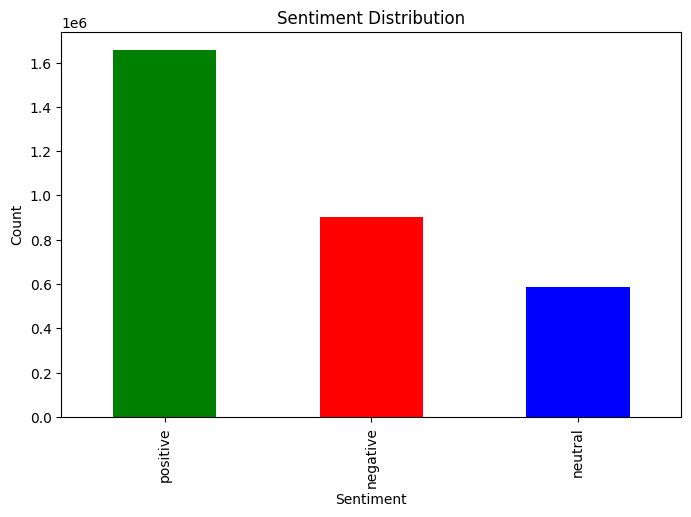

In [58]:
analyzer.plot_sentiment_distribution()


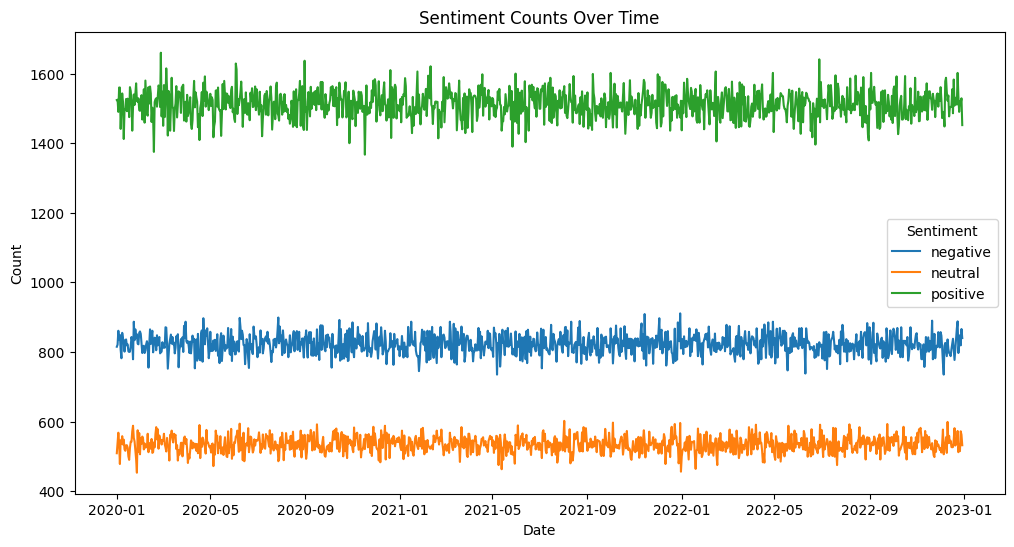

In [59]:
analyzer.sentiment_over_time()


In [60]:
analyzer.highlight_extreme_tweets()


Most Positive Tweet:
 Kobe you're the best, Kobe you're the best, Kobe you're the best, Kobe you're the best, you're best LA will ever have...  Like that remix?
Compound Score: 0.9882

Most Negative Tweet:
 @cupidalaska nope not in NY - should be but ya knows. i need muchos makeovers my nails are damn awful. boy troubles are the worst. 
Compound Score: -0.97975


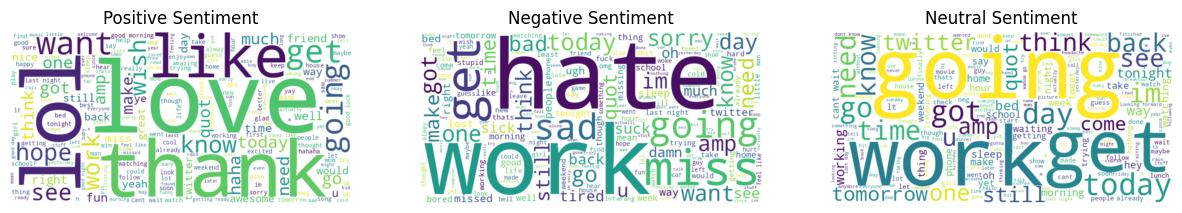

In [61]:
positive_wordcloud = analyzer.generate_wordcloud('positive')
negative_wordcloud = analyzer.generate_wordcloud('negative')
neutral_wordcloud = analyzer.generate_wordcloud('neutral')

# Plot the word clouds
fig, axs = plt.subplots(1, 3, figsize=(15, 5))
axs[0].imshow(positive_wordcloud, interpolation='bilinear')
axs[0].set_title('Positive Sentiment')
axs[0].axis('off')

axs[1].imshow(negative_wordcloud, interpolation='bilinear')
axs[1].set_title('Negative Sentiment')
axs[1].axis('off')

axs[2].imshow(neutral_wordcloud, interpolation='bilinear')
axs[2].set_title('Neutral Sentiment')
axs[2].axis('off')

plt.show()


Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

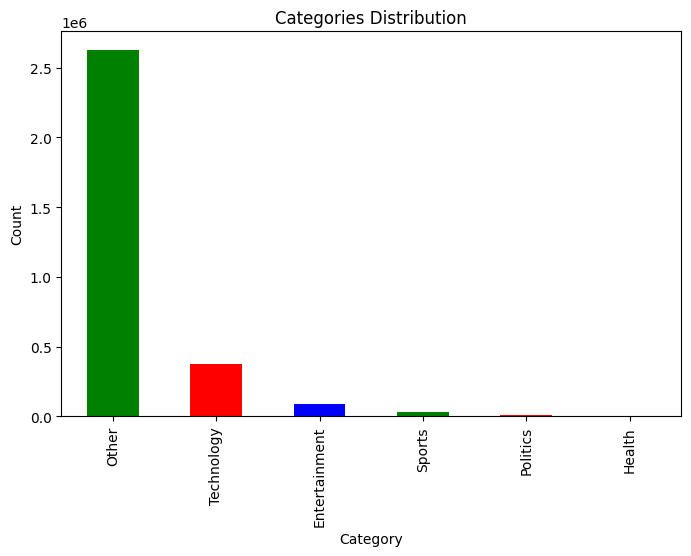

In [62]:
analyzer.plot_categories_distribution()

# Saving the Python source file to Colab environment

In [61]:
# Write the Utils class to a Python file
with open('Utils.py', 'w') as f:
    f.write('''
class Utils:
  # A dictionary where keys are category names, and values are lists of keywords related to each category.
  categories = {
    "Politics": ["election", "vote", "president", "government", "policy"],
    "Sports": ["football", "cricket", "soccer", "game", "match"],
    "Health": ["covid", "pandemic", "health", "vaccine", "virus"],
    "Technology": ["tech", "AI", "machine learning", "gadget", "software"],
    "Entertainment": ["movie", "music", "actor", "show", "series"]
  }

  # Define a helper function to match a tweet to a category based on keywords
  def match_category(self, text):
    for category, keywords in self.categories.items():
      for keyword in keywords:
        if keyword.lower() in text.lower():
          return category
    return "Other"  # Default category if no match is found

  # Generate random timestamps within the date range
  def random_date(self, start, end):
      return start + pd.to_timedelta(
          np.random.randint(0, int((end - start).total_seconds())), unit='s'
      )

  # Add a random datetime column to the dataset for sentiment fluctuation analysis.
  # Args: start_date (str): The start date in 'YYYY-MM-DD' format.
  #       end_date (str): The end date in 'YYYY-MM-DD' format.
  #       df: DataFrame to which the datetime column needs to be added
  # Returns: pd.DataFrame: The updated DataFrame with an added 'timestamp' column.
  def add_random_datetime(self, start_date, end_date, df):
    # Convert start and end dates to pandas Timestamps
    start = pd.to_datetime(start_date)
    end = pd.to_datetime(end_date)

    # Apply the random timestamp generation
    df['timestamp'] = [self.random_date(start, end) for _ in range(len(df))]
    return df
''')

In [62]:
# Write the TweetSentimentAnalysis class to a Python file
with open('TweetSentimentAnalysis.py', 'w') as f:
    f.write('''
import pandas as pd
import numpy as np

import nltk
from nltk.corpus import stopwords
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from textblob import TextBlob
import re
import matplotlib.pyplot as plt

from wordcloud import WordCloud

from sklearn.metrics import accuracy_score, classification_report

# library used for showing progress bar
from tqdm.notebook import tqdm
from tqdm._tqdm_notebook import tqdm_notebook

# Swifter library speeds up applying functions on pandas DataFrames or Series by
# automatically choosing vectorization, multithreading, or parallel processing.
# It requires minimal code changes, making it ideal for handling large datasets efficiently.
import swifter

from Utils import Utils

class TweetSentimentAnalysis:
  # This class performs sentiment analysis on tweets using the VADER library.
  # It includes functionalities for data cleaning, sentiment computation, and visualizations.

  # Initialize the TweetSentimentAnalysis class with the dataset path.
  # Args: dataset_path (str): Path to the CSV dataset file.
  def __init__(self, dataset_path):
    self.dataset_path = dataset_path
    self.df = None
    self.analyzer = SentimentIntensityAnalyzer()
    self.stop_words = set(stopwords.words('english'))
    self.utils = Utils()

  # Load the dataset from the given CSV file.
  # Returns: DataFrame: The loaded dataset.
  def load_data(self, df_tweets):
    self.df = df_tweets
    return self.df

  @staticmethod
  # Clean a single tweet by removing URLs, mentions, hashtags, numbers, and punctuation.
  # Args: tweet (str): The raw tweet text.
  # Returns: str: The cleaned tweet text.
  def clean_tweet(tweet):
    tweet = re.sub(r'http\S+', '', tweet)  # Remove URLs
    tweet = re.sub(r'@\w+', '', tweet)  # Remove mentions
    tweet = re.sub(r'#', '', tweet)  # Remove hashtags
    tweet = re.sub(r'\d+', '', tweet)  # Remove numbers
    tweet = re.sub(r'[^\w\s]', '', tweet)  # Remove punctuation
    tweet = re.sub(r'[^A-Za-z0-9\s]', '', tweet) # Remove special characters
    return tweet.lower()

  # Preprocess all tweets in the dataset by cleaning the text.
  # Adds a new column 'cleaned_text' to the DataFrame.
  def preprocess_tweets(self):
    tqdm.pandas(desc="Preprocessing Tweets")
    self.df['cleaned_text'] = self.df['tweet'].swifter.apply(self.clean_tweet)

  # Compute sentiment scores for each tweet using VADER.
  # Adds 'compound' and 'vader_label' columns to the DataFrame.
  def analyze_sentiments(self):
    tqdm.pandas(desc="Analyzing Sentiments")
    self.df['vader_scores'] = self.df['cleaned_text'].swifter.apply(self.analyzer.polarity_scores)
    self.df['compound'] = self.df['vader_scores'].swifter.apply(lambda x: x['compound'])
    self.df['vader_label'] = self.df['compound'].swifter.apply(
    lambda x: 'positive' if x > 0.05 else ('negative' if x < -0.05 else 'neutral'))

  # Plot a bar chart showing the distribution of sentiments in the dataset.
  def plot_sentiment_distribution(self):
    sentiment_counts = self.df['vader_label'].value_counts()
    plt.figure(figsize=(8, 5))
    sentiment_counts.plot(kind='bar', color=['green', 'red', 'blue'])
    plt.title("Sentiment Distribution")
    plt.xlabel("Sentiment")
    plt.ylabel("Count")
    plt.show()

  # Plot how sentiment counts change over time.
  def sentiment_over_time(self):
    start_date = "2020-01-01"  # Start of COVID-19 pandemic
    end_date = "2022-12-31"    # End date for the analysis

    self.df = self.utils.add_random_datetime(start_date, end_date, self.df)

    self.df['date'] = self.df['timestamp'].dt.date
    sentiment_over_time = self.df.groupby(['date', 'vader_label']).size().unstack(fill_value=0)
    sentiment_over_time.plot(kind='line', figsize=(12, 6))
    plt.title("Sentiment Counts Over Time")
    plt.xlabel("Date")
    plt.ylabel("Count")
    plt.legend(title="Sentiment")
    plt.show()

  # Print the most positive and most negative tweets based on compound scores.
  def highlight_extreme_tweets(self):
    most_positive = self.df.loc[self.df['compound'].idxmax()]
    most_negative = self.df.loc[self.df['compound'].idxmin()]

    print("Most Positive Tweet:\n", most_positive['tweet'])
    print("Compound Score:", most_positive['compound'])
    print("\nMost Negative Tweet:\n", most_negative['tweet'])
    print("Compound Score:", most_negative['compound'])

  # Generate and display a word cloud for tweets of a specific sentiment.
  # Args: sentiment_label (str): The sentiment to generate the word cloud for ('positive', 'negative', or 'neutral').
  def generate_wordcloud(self, sentiment_label):
    tqdm.pandas(desc="Generating WordCloud")
    text_data = self.df[self.df['vader_label'] == sentiment_label]['cleaned_text']
    wordcloud = WordCloud(width=800, height=400, background_color='white', stopwords=self.stop_words).generate(
          ' '.join(text_data)
    )
    return wordcloud

  # Compare VADER predictions with actual labels and calculate accuracy.
  # Returns: float: The accuracy score.
  def evaluate_accuracy(self):
    actual = self.df['sentiment']

    label_mapping = {'negative': 0, 'positive': 1, 'neutral': 2}
    self.df['vader_label_num'] = self.df['vader_label'].map(label_mapping)

    predicted = self.df['vader_label_num']
    accuracy = accuracy_score(actual, predicted)
    print("Accuracy:", accuracy)
    print("\nClassification Report:\n", classification_report(actual, predicted))
    return accuracy

  # Categorize tweets based on their subject/domain using predefined keywords.
  # Args: None
  # Returns: pd.DataFrame: The updated DataFrame with an added 'category' column.
  def categorize_tweets(self):
    # Apply the helper function to the 'tweet' column
    self.df['category'] = self.df['cleaned_text'].swifter.apply(self.utils.match_category)

  # Plot a bar chart showing the distribution of categories in the dataset.
  def plot_categories_distribution(self):
    self.categorize_tweets()
    categories_counts = self.df['category'].value_counts()
    plt.figure(figsize=(8, 5))
    categories_counts.plot(kind='bar', color=['green', 'red', 'blue'])
    plt.title("Categories Distribution")
    plt.xlabel("Category")
    plt.ylabel("Count")
    plt.show()

  # Techniques to help improve accuracy of the model
  # Approach 1 - Fine-Tune Sentiment Thresholds
  # Compute sentiment scores for each tweet using VADER and a custom threshold.
  # Adds 'compound' and 'vader_label' columns to the DataFrame.
  def analyze_sentiments_custom_threshold(self, threshold):
    tqdm.pandas(desc="Analyzing Sentiments")
    self.df['vader_scores'] = self.df['cleaned_text'].swifter.apply(self.analyzer.polarity_scores)
    self.df['compound'] = self.df['vader_scores'].swifter.apply(lambda x: x['compound'])
    self.df['vader_label'] = self.df['compound'].swifter.apply(
    lambda x: 'positive' if x > threshold else ('negative' if x < (-1 * threshold) else 'neutral'))

  # Approach 2 - Use Ensemble Techniques
  # Compute sentiment scores for each tweet using VADER and TextBlob and use average sentiment scores.
  # Adds 'compound', 'ensemble_label' columns to the DataFrame.
  def analyze_sentiments_ensemble(self, threshold):
    tqdm.pandas(desc="Analyzing Sentiments")
    self.df['vader_scores'] = self.df['cleaned_text'].swifter.apply(self.analyzer.polarity_scores)
    self.df['textblob_scores'] = self.df['cleaned_text'].swifter.apply(lambda text: TextBlob(text).sentiment.polarity)
    self.df['compound'] = self.df['vader_scores'].swifter.apply(lambda x: x['compound'])

    # Compute the average of textblob_scores and compound columns and store in compound
    self.df['compound'] = self.df[['textblob_scores', 'compound']].apply(lambda row: row.mean(), axis=1)

    self.df['vader_label'] = self.df['compound'].swifter.apply(
    lambda x: 'positive' if x > threshold else ('negative' if x < (-1 * threshold) else 'neutral'))

''')

# Creating custom library from source files saved in Google Drive

In [67]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [20]:
# Necessary folder structure and files for creating the library were saved to my Google Drive
!ls /content/drive/MyDrive/TweetSentimentAnalysis_lib

README.md  setup.py  TweetSentimentAnalysis_lib


In [21]:
!ls /content/drive/MyDrive/TweetSentimentAnalysis_lib/TweetSentimentAnalysis_lib

__init__.py  TweetSentimentAnalysis.py	Utils.py


# Installing the custom library created

In [22]:
!pip install /content/drive/MyDrive/TweetSentimentAnalysis_lib

Processing ./drive/MyDrive/TweetSentimentAnalysis_lib
  Preparing metadata (setup.py) ... done
  Created wheel for TweetSentimentAnalysis_lib: filename=TweetSentimentAnalysis_lib-1.0.0-py3-none-any.whl size=5214 sha256=7d7ee3b5ce5bf967a6ab879d3fc7c3006abcf882e690698aa5e1c539d26af98f
  Stored in directory: /tmp/pip-ephem-wheel-cache-zw7hk8bv/wheels/ac/23/81/9afdcbdb7313186a3c75810bab107c18ce7b5aac06c5b01eef
Successfully built TweetSentimentAnalysis_lib
  Attempting uninstall: TweetSentimentAnalysis_lib
    Found existing installation: TweetSentimentAnalysis_lib 1.0.0
    Uninstalling TweetSentimentAnalysis_lib-1.0.0:
      Successfully uninstalled TweetSentimentAnalysis_lib-1.0.0


# Importing and invoking methods from the custom library created

In [22]:
from TweetSentimentAnalysis_lib import TweetSentimentAnalysis, Utils

analyzer = TweetSentimentAnalysis("/content/dataset/twitter_dataset.csv")  # Replace with the actual dataset path
df = analyzer.load_data(df_tweets)


In [23]:
analyzer.preprocess_tweets()

Pandas Apply:   0%|          | 0/3142321 [00:00<?, ?it/s]

# Brief Summary of the findings

**Key Aspects of the Dataset**

*Size and Source of the dataset*: Contains 3 million labeled tweets from Kaggle, offering a large dataset for robust analysis.

*Key Features*: Includes raw tweet text and sentiment labels (positive, negative, neutral). We have created simulated timestamps to allow for temporal sentiment analysis, mimicking real-world trends over time.

*Versatility of this dataset*: Diverse content spanning multiple topics (Politics, Health, Sports, Technology, Entertainment), enabling multi-dimensional analysis.

**Key Highlights of Python Code**

*Preprocessing and Data Cleaning*: Preprocessing involved cleaning tweets by removing URLs, mentions, hashtags, numbers, and punctuation.
Use of Swifter for efficient parallelized operations on large datasets.

*Sentiment Analysis*: Leveraged VADER to classify tweets into positive, neutral, and negative sentiments.
Added compound scores and corresponding sentiment labels to the dataset.
Also explored multiple approaches to improve the accuracy including adjusting thresholds and using ensemble techniques

*Extreme Sentiment Insights*: Identified and highlighted the most positive and most negative tweets for qualitative understanding.

*Word Cloud Analysis*: Unique visual representation of dominant words for each sentiment category.

*Categorization of Tweets*: The raw dataset provided the opportunity to categorize the tweets to predefined topics using keyword-based logic.
Generated category distributions to explore discussion themes in the dataset.

*Evaluation Metrics*: Achieved moderate accuracy by comparing VADER predictions with actual sentiment labels.
Provided a classification report detailing prediction performance.
Also explored multiple approaches to improve the accuracy including adjusting thresholds and using ensemble techniques

*Visualizations*: Rich visual outputs include bar charts, time-series sentiment plots, and word clouds.


**Unique Strengths of the code base**

*Scalability*: Optimized for large datasets using Swifter and tqdm progress bars.

*Flexibility*: Combines sentiment analysis with topic classification, enabling dual-layer insights.

*Extensibility*: Modular design allows easy enhancement, such as integrating advanced NLP models like BERT in the future.

*Industry standard best practices*: Comprehensive unit tests were developed to ensure robust functionality and maintain high code quality aligning with DevOps practices, also a custom library was created, designed not only for internal reuse but also to contribute to the open-source community, enabling other developers to easily integrate and leverage its functionality in their projects. This approach fosters collaboration, reusability, and adherence to modern software development standards.

This analysis stands out for its ability to process a massive dataset efficiently, extract diverse insights, and provide actionable visualizations, all within a relatively simple yet effective Python implementation.